# Validity of using prescription records to identify patient comorbidities
## Combined Analysis of epilepsy

**ReadMe:**
- This is a script used in the analysis for Schnier et al., 2025: Validity of using prescription records to classify disease – a record linkage study using routinely collected electronic health records from the UK.
- The underlying data set has been created using the Optimum Patient Care Research Database (https://opcrd.optimumpatientcare.org/). The authors do not have permission to give the public access to the study dataset; researchers may request access to OPCRD for their own purposes. 
 - All code is run in StataSE 18. 


**Set up:**
|Var|Input|
| --- | --- | 
|population|425,000|
|diagnostic codes|Open coding code list|
|drug codes|bnf 040801 and 040802|
|sql date|13.03.2025|
|sql code|epilepsyselection_202050313.sql| 

In [54]:
    clear all

### Import from SQL server and data wrangling

In [55]:
odbc load, exec("select * from [epilepsy_425000_20250313]") dsn("sqlserverconnect")

In [56]:
generate test=0 if missing(drug_dt)
replace test=1 if ! missing(drug_dt)  

generate diag=0 if missing(diag_dt)
replace diag=1 if ! missing(diag_dt)  

gen start_year=year(fu_start_dt)


egen agecat = cut(age), at(16,30,70,120)
label def agecat_lab 16 "Young" 30 "0Middle" 70 "Elderly" 120 "weird"
label values agecat agecat_lab


egen yearcat = cut(start_year), at(2004,2010,2016,2025)
label def yearcat_lab 2004 "2004-2009" 2010 "2010-2015" 2016 "2016-2020" 
label values yearcat yearcat_lab

egen imdcat = cut(imd_decile), at(0,4,8,11)
label def imdcat_lab 0 "1-3" 4 "4-7" 8 "8-10" 
label values imdcat imdcat_lab

replace bnf_code = "Anxiolytics" if bnf_code== "040102"
replace bnf_code = "Mania and hypomania" if bnf_code== "040203"
replace bnf_code = "Control for epilepsy" if bnf_code== "040801"
replace bnf_code = "Drugs used in status epilepticus" if bnf_code== "040802"
replace bnf_code = "Betablockers" if bnf_code== "110600" 

gen bnf_code2 =  "Control for epilepsy" if bnf_code== "Control for epilepsy"
replace bnf_code2 = "Other" if bnf_code!= "Control for epilepsy" & ! missing(bnf_code)
encode bnf_code, generate(bnf_code_values)
encode description, generate(description_values)
encode bnf_code2, generate(bnf_code_values2)



replace ethnicity="0white" if ethnicity=="1"
replace ethnicity="Other" if ethnicity=="2"
replace ethnicity="Other" if ethnicity=="3"
replace ethnicity="Other" if ethnicity=="4"
replace ethnicity="Other" if ethnicity=="5"
replace ethnicity="Missing" if ethnicity=="99"




encode ethnicity, generate(ethnicity_values) 

gen diag_neg=diag==0
gen diag_pos=diag==1
encode region_name, generate(region) label(regionlbl)
encode ethnicity, generate(ethnic)


(23,514 missing values generated)
(23,514 real changes made)
(2,938 missing values generated)
(2,938 real changes made)
(2,589 missing values generated)
variable bnf_code was str6 now str11
(45 real changes made)
variable bnf_code was str11 now str19
(364 real changes made)
variable bnf_code was str19 now str20
(22,986 real changes made)
variable bnf_code was str20 now str32
(18 real changes made)
(6 real changes made)
(402,014 missing values generated)
(437 real changes made)
variable ethnicity was str2 now str6
(257,981 real changes made)
(3,762 real changes made)
(23,912 real changes made)
(7,430 real changes made)
(8,764 real changes made)
variable ethnicity was str6 now str7
(123,151 real changes made)


(bin=19, start=16, width=5)


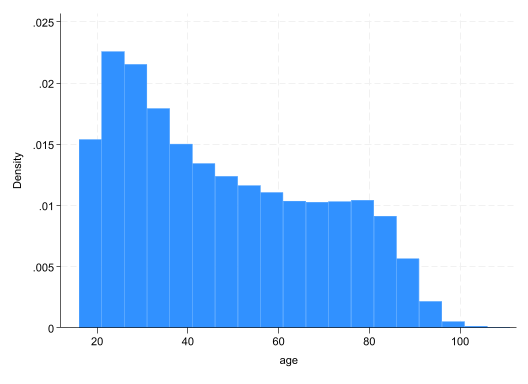

In [57]:
histogram age, width(5)


This table holds one randomly selected diagnostic code found during the observation period. The table is truncated to only include diagnostic codes with a count of 10 or more.

In [58]:
set linesize 132
groups description , select(f >= 10) ord(h) table 


  +-------------------------------------------------------------+
  |                       description   Freq.   Percent     %<= |
  |-------------------------------------------------------------|
  |                          Epilepsy    1131     38.50   38.50 |
  |                     Fit frequency     538     18.31   56.81 |
  |               Epilepsy monitoring     367     12.49   69.30 |
  |                          Last fit     297     10.11   79.41 |
  |                 Epilepsy resolved      66      2.25   81.65 |
  |-------------------------------------------------------------|
  |                 Epileptic seizure      56      1.91   83.56 |
  |            Temporal lobe epilepsy      56      1.91   85.47 |
  |              Generalized epilepsy      52      1.77   87.24 |
  |        Grand mal (major) epilepsy      46      1.57   88.80 |
  |                  Fit - convulsion      34      1.16   89.96 |
  |-------------------------------------------------------------|
  |      

These tables holds one randomly selected prescrption during the observation period. The table is truncated to only include codes with a count of 10 or more.


In [59]:
set linesize 132
groups bnf_code , select(f >= 10) ord(h) table 


  +------------------------------------------------------------+
  |                         bnf_code   Freq.   Percent     %<= |
  |------------------------------------------------------------|
  |             Control for epilepsy   22986     98.13   98.13 |
  |              Mania and hypomania     364      1.55   99.69 |
  |                      Anxiolytics      45      0.19   99.88 |
  | Drugs used in status epilepticus      18      0.08   99.96 |
  +------------------------------------------------------------+


### Results
#### Overall

In [60]:
diagt diag test


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     2,712        226 |     2,938 
    Normal |    20,802    401,260 |   422,062 
-----------+----------------------+----------
     Total |    23,514    401,486 |   425,000 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      0.7%      0.7%       0.7%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     92.3%     91.3%     93.2%
Specificity                      Pr(-|N)     95.1%     95.0%     95.1%
ROC area               (Sens. + Spec.)/2      0.94      0.93      0.94 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     18.73     18.

#### Males

In [61]:
diagt diag test if sex==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     1,420        134 |     1,554 
    Normal |     8,729    198,002 |   206,731 
-----------+----------------------+----------
     Total |    10,149    198,136 |   208,285 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      0.7%      0.7%       0.8%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     91.4%     89.9%     92.7%
Specificity                      Pr(-|N)     95.8%     95.7%     95.9%
ROC area               (Sens. + Spec.)/2      0.94      0.93      0.94 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     21.64     21.

#### Females

In [62]:
diagt diag test if sex==0


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     1,292         92 |     1,384 
    Normal |    12,073    203,249 |   215,322 
-----------+----------------------+----------
     Total |    13,365    203,341 |   216,706 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      0.6%      0.6%       0.7%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     93.4%     91.9%     94.6%
Specificity                      Pr(-|N)     94.4%     94.3%     94.5%
ROC area               (Sens. + Spec.)/2      0.94      0.93      0.95 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     16.65     16.

#### Age
*16-30*

In [63]:
diagt diag test if agecat==16


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |       455         64 |       519 
    Normal |     1,769    115,386 |   117,155 
-----------+----------------------+----------
     Total |     2,224    115,450 |   117,674 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      0.4%      0.4%       0.5%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     87.7%     84.5%     90.4%
Specificity                      Pr(-|N)     98.5%     98.4%     98.6%
ROC area               (Sens. + Spec.)/2      0.93      0.92      0.94 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     58.06     54.

*30-69*

In [64]:
diagt diag test if agecat==30


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     1,564        126 |     1,690 
    Normal |    11,860    207,845 |   219,705 
-----------+----------------------+----------
     Total |    13,424    207,971 |   221,395 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      0.8%      0.7%       0.8%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     92.5%     91.2%     93.8%
Specificity                      Pr(-|N)     94.6%     94.5%     94.7%
ROC area               (Sens. + Spec.)/2      0.94      0.93      0.94 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     17.14     16.

*>69*

In [65]:
diagt diag test if agecat==70


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |       693         36 |       729 
    Normal |     7,173     78,029 |    85,202 
-----------+----------------------+----------
     Total |     7,866     78,065 |    85,931 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      0.8%      0.8%       0.9%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     95.1%     93.2%     96.5%
Specificity                      Pr(-|N)     91.6%     91.4%     91.8%
ROC area               (Sens. + Spec.)/2      0.93      0.93      0.94 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     11.29     10.

#### Year at start of oberservation period 
*2004-2009*

In [66]:
diagt diag test if yearcat==2004


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     1,222        100 |     1,322 
    Normal |     4,911    143,767 |   148,678 
-----------+----------------------+----------
     Total |     6,133    143,867 |   150,000 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      0.9%      0.8%       0.9%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     92.4%     90.9%     93.8%
Specificity                      Pr(-|N)     96.7%     96.6%     96.8%
ROC area               (Sens. + Spec.)/2      0.95      0.94      0.95 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     27.98     27.

*2010-2015*

In [67]:
diagt diag test if yearcat==2010


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |       965         61 |     1,026 
    Normal |     7,992    140,982 |   148,974 
-----------+----------------------+----------
     Total |     8,957    141,043 |   150,000 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      0.7%      0.6%       0.7%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     94.1%     92.4%     95.4%
Specificity                      Pr(-|N)     94.6%     94.5%     94.7%
ROC area               (Sens. + Spec.)/2      0.94      0.94      0.95 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     17.53     17.

*2016-2020*

In [68]:
diagt diag test if yearcat==2016


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |       525         65 |       590 
    Normal |     7,899    116,511 |   124,410 
-----------+----------------------+----------
     Total |     8,424    116,576 |   125,000 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      0.5%      0.4%       0.5%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     89.0%     86.2%     91.4%
Specificity                      Pr(-|N)     93.7%     93.5%     93.8%
ROC area               (Sens. + Spec.)/2      0.91      0.90      0.93 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     14.01     13.

#### IMD of practice
*1-3*

In [69]:
diagt diag test if imdcat==0


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     1,059         92 |     1,151 
    Normal |     7,806    145,594 |   153,400 
-----------+----------------------+----------
     Total |     8,865    145,686 |   154,551 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      0.7%      0.7%       0.8%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     92.0%     90.3%     93.5%
Specificity                      Pr(-|N)     94.9%     94.8%     95.0%
ROC area               (Sens. + Spec.)/2      0.93      0.93      0.94 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     18.08     17.

*4-7*

In [70]:
diagt diag test if imdcat==4


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |       908         65 |       973 
    Normal |     7,344    134,728 |   142,072 
-----------+----------------------+----------
     Total |     8,252    134,793 |   143,045 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      0.7%      0.6%       0.7%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     93.3%     91.6%     94.8%
Specificity                      Pr(-|N)     94.8%     94.7%     94.9%
ROC area               (Sens. + Spec.)/2      0.94      0.93      0.95 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     18.05     17.

*8-10*

In [71]:
diagt diag test if imdcat==8


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |       735         68 |       803 
    Normal |     5,618    118,394 |   124,012 
-----------+----------------------+----------
     Total |     6,353    118,462 |   124,815 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      0.6%      0.6%       0.7%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     91.5%     89.4%     93.4%
Specificity                      Pr(-|N)     95.5%     95.4%     95.6%
ROC area               (Sens. + Spec.)/2      0.94      0.93      0.94 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     20.20     19.

#### Commissioning Regions
EAST OF ENGLAND

In [72]:
diagt diag test if regexm(region_name,"ENGLAND")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |       532         44 |       576 
    Normal |     5,220     83,841 |    89,061 
-----------+----------------------+----------
     Total |     5,752     83,885 |    89,637 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      0.6%      0.6%       0.7%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     92.4%     89.9%     94.4%
Specificity                      Pr(-|N)     94.1%     94.0%     94.3%
ROC area               (Sens. + Spec.)/2      0.93      0.92      0.94 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     15.76     15.

London

In [73]:
diagt diag test if regexm(region_name,"LONDON")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |        83          4 |        87 
    Normal |       434     16,204 |    16,638 
-----------+----------------------+----------
     Total |       517     16,208 |    16,725 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      0.5%      0.4%       0.6%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     95.4%     88.6%     98.7%
Specificity                      Pr(-|N)     97.4%     97.1%     97.6%
ROC area               (Sens. + Spec.)/2      0.96      0.94      0.99 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     36.57     32.

Midlands

In [74]:
diagt diag test if regexm(region_name,"MID")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |       359         40 |       399 
    Normal |     2,463     43,681 |    46,144 
-----------+----------------------+----------
     Total |     2,822     43,721 |    46,543 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      0.9%      0.8%       0.9%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     90.0%     86.6%     92.7%
Specificity                      Pr(-|N)     94.7%     94.5%     94.9%
ROC area               (Sens. + Spec.)/2      0.92      0.91      0.94 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     16.86     16.

Yorkshire

In [75]:
diagt diag test if regexm(region_name,"YORK")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |       585         52 |       637 
    Normal |     4,064     81,410 |    85,474 
-----------+----------------------+----------
     Total |     4,649     81,462 |    86,111 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      0.7%      0.7%       0.8%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     91.8%     89.4%     93.8%
Specificity                      Pr(-|N)     95.2%     95.1%     95.4%
ROC area               (Sens. + Spec.)/2      0.94      0.92      0.95 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     19.32     18.

North West

In [76]:
diagt diag test if regexm(region_name,"NORTH")==1 & regexm(region_name,"WEST")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |       342         30 |       372 
    Normal |     2,378     44,843 |    47,221 
-----------+----------------------+----------
     Total |     2,720     44,873 |    47,593 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      0.8%      0.7%       0.9%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     91.9%     88.7%     94.5%
Specificity                      Pr(-|N)     95.0%     94.8%     95.2%
ROC area               (Sens. + Spec.)/2      0.93      0.92      0.95 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     18.26     17.

South East

In [77]:
diagt diag test if regexm(region_name,"SOUTH")==1 & regexm(region_name,"EAST")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |       495         42 |       537 
    Normal |     3,925     86,023 |    89,948 
-----------+----------------------+----------
     Total |     4,420     86,065 |    90,485 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      0.6%      0.5%       0.6%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     92.2%     89.6%     94.3%
Specificity                      Pr(-|N)     95.6%     95.5%     95.8%
ROC area               (Sens. + Spec.)/2      0.94      0.93      0.95 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     21.12     20.

South West

In [78]:
diagt diag test if regexm(region_name,"SOUTH")==1 & regexm(region_name,"WEST")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |       239          8 |       247 
    Normal |     1,938     33,991 |    35,929 
-----------+----------------------+----------
     Total |     2,177     33,999 |    36,176 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      0.7%      0.6%       0.8%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     96.8%     93.7%     98.6%
Specificity                      Pr(-|N)     94.6%     94.4%     94.8%
ROC area               (Sens. + Spec.)/2      0.96      0.95      0.97 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     17.94     17.

#### System
SystmOne

In [79]:
diagt diag test if regexm(system,"One")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     1,419        114 |     1,533 
    Normal |    12,210    215,012 |   227,222 
-----------+----------------------+----------
     Total |    13,629    215,126 |   228,755 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      0.7%      0.6%       0.7%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     92.6%     91.1%     93.8%
Specificity                      Pr(-|N)     94.6%     94.5%     94.7%
ROC area               (Sens. + Spec.)/2      0.94      0.93      0.94 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     17.23     16.

Vision

In [80]:
diagt diag test if regexm(system,"Vision")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |        88          7 |        95 
    Normal |       495     13,154 |    13,649 
-----------+----------------------+----------
     Total |       583     13,161 |    13,744 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      0.7%      0.6%       0.8%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     92.6%     85.4%     97.0%
Specificity                      Pr(-|N)     96.4%     96.0%     96.7%
ROC area               (Sens. + Spec.)/2      0.95      0.92      0.97 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     25.54     23.

EMIS

In [81]:
diagt diag test if regexm(ustrupper(system),"EMIS")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     1,204        105 |     1,309 
    Normal |     8,084    172,972 |   181,056 
-----------+----------------------+----------
     Total |     9,288    173,077 |   182,365 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      0.7%      0.7%       0.8%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     92.0%     90.4%     93.4%
Specificity                      Pr(-|N)     95.5%     95.4%     95.6%
ROC area               (Sens. + Spec.)/2      0.94      0.93      0.94 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     20.60     20.

#### RA_Index
Index==1

In [82]:
diagt diag test if RA_index==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     2,062        167 |     2,229 
    Normal |    15,420    304,048 |   319,468 
-----------+----------------------+----------
     Total |    17,482    304,215 |   321,697 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      0.7%      0.7%       0.7%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     92.5%     91.3%     93.6%
Specificity                      Pr(-|N)     95.2%     95.1%     95.2%
ROC area               (Sens. + Spec.)/2      0.94      0.93      0.94 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     19.17     18.

Index==0

In [83]:
diagt diag test if RA_index==0


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |       650         59 |       709 
    Normal |     5,382     97,212 |   102,594 
-----------+----------------------+----------
     Total |     6,032     97,271 |   103,303 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      0.7%      0.6%       0.7%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     91.7%     89.4%     93.6%
Specificity                      Pr(-|N)     94.8%     94.6%     94.9%
ROC area               (Sens. + Spec.)/2      0.93      0.92      0.94 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     17.48     16.

#### Ethnicity
Ethnicity==0000white

In [84]:
diagt diag test if ethnicity=="0white"


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     1,954        147 |     2,101 
    Normal |    15,666    240,214 |   255,880 
-----------+----------------------+----------
     Total |    17,620    240,361 |   257,981 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      0.8%      0.8%       0.8%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     93.0%     91.8%     94.1%
Specificity                      Pr(-|N)     93.9%     93.8%     94.0%
ROC area               (Sens. + Spec.)/2      0.93      0.93      0.94 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     15.19     14.

In [85]:
diagt diag test if ethnicity=="Other"


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |       145         21 |       166 
    Normal |     1,440     42,262 |    43,702 
-----------+----------------------+----------
     Total |     1,585     42,283 |    43,868 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      0.4%      0.3%       0.4%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     87.3%     81.3%     92.0%
Specificity                      Pr(-|N)     96.7%     96.5%     96.9%
ROC area               (Sens. + Spec.)/2      0.92      0.89      0.95 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     26.51     24.

In [86]:
diagt diag test if ethnicity=="Missing"


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |       613         58 |       671 
    Normal |     3,696    118,784 |   122,480 
-----------+----------------------+----------
     Total |     4,309    118,842 |   123,151 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      0.5%      0.5%       0.6%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     91.4%     89.0%     93.4%
Specificity                      Pr(-|N)     97.0%     96.9%     97.1%
ROC area               (Sens. + Spec.)/2      0.94      0.93      0.95 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     30.27     29.

In [87]:
tempname memhold
postfile `memhold' str20 var prev sens spec ppv npv roc using "validity.dta",replace

quietly diagt diag test
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("all") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if sex==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Male") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if sex==0
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Female") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if agecat==16
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Age young") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if agecat==30
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Age middle") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if agecat==70
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Age elderly") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 


quietly diagt diag test if yearcat==2004
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Year 2004-2009") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if yearcat==2010
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Year 2010-2015") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc')

quietly diagt diag test if yearcat==2016
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Year 2016-2020") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 


quietly diagt diag test if imdcat==0
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("IMD 1,3") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if imdcat==4
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("IMD 4,7") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if imdcat==8
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("IMD 8,10") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 


quietly diagt diag test if regexm(region_name,"LONDON")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("London") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(region_name,"MID")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Midlands") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(region_name,"YORK")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Yorkshire") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(region_name,"NORTH")==1 & regexm(region_name,"WEST")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("North West") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(region_name,"SOUTH")==1 & regexm(region_name,"EAST")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("South East") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(region_name,"SOUTH")==1 & regexm(region_name,"WEST")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("South West") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(system,"One")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("SystemOne") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(system,"Vision")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Vision") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(ustrupper(system),"EMIS")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("EMIS") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if RA_index==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("RAIndex1") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if RA_index==0
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("RAIndex0") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if ethnicity=="0white"
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Ethnicity_0white") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if ethnicity=="Other"
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Ethnicity_Other") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 



quietly diagt diag test if ethnicity=="Missing"
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Ethnicity_Missing") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

postclose `memhold'

### Logistic Regression
#### PPV

In [88]:
drop if missing(imdcat)
drop if missing(sex)

(2,589 observations deleted)
(9 observations deleted)


In [89]:
logistic diag_pos if test==1


Logistic regression                                     Number of obs = 23,470
                                                        LR chi2(0)    =   0.00
                                                        Prob > chi2   =      .
Log likelihood = -8381.1238                             Pseudo R2     = 0.0000

------------------------------------------------------------------------------
    diag_pos |       Odds   Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
       _cons |    .130104   .0026608   -99.72   0.000     .1249921    .1354249
------------------------------------------------------------------------------


In [91]:
gen newdiag=diag_pos

melogit newdiag i.sex i.yearcat i.agecat  i.region RA_index i.ethnic i.imdcat if test==1 || practice_id:,or
estimates store model1


Fitting fixed-effects model:

Iteration 0:  Log likelihood = -8000.4033  
Iteration 1:  Log likelihood = -7819.9014  
Iteration 2:  Log likelihood = -7817.5275  
Iteration 3:  Log likelihood = -7817.5268  

Refining starting values:

Grid node 0:  Log likelihood = -7870.0348

Fitting full model:

Iteration 0:  Log likelihood = -7870.0348  (not concave)
Iteration 1:  Log likelihood = -7824.0975  (not concave)
Iteration 2:  Log likelihood = -7790.0919  
Iteration 3:  Log likelihood = -7789.5046  
Iteration 4:  Log likelihood = -7789.5013  
Iteration 5:  Log likelihood = -7789.5013  

Mixed-effects logistic regression               Number of obs     =     23,386
Group variable: practice_id                     Number of groups  =        320

                                                Obs per group:
                                                              min =          1
                                                              avg =       73.1
                              

##### Likelihood ratio tests

In [92]:


quietly: melogit newdiag i.sex i.yearcat i.agecat  i.region RA_index i.ethnic if test==1 || practice_id:,or
estimates store model_imd

quietly:melogit newdiag i.sex i.yearcat i.agecat  i.region RA_index i.imdcat if test==1 || practice_id:,or
estimates store model_ethnicity

quietly:melogit newdiag i.yearcat i.agecat  i.region RA_index i.ethnic i.imdcat if test==1 || practice_id:,or
estimates store model_sex

quietly:melogit newdiag i.sex i.agecat  i.region RA_index i.ethnic i.imdcat if test==1 || practice_id:,or
estimates store model_year

quietly: melogit newdiag i.sex i.yearcat  i.region RA_index i.ethnic i.imdcat if test==1 || practice_id:,or
estimates store model_age



In [93]:
lrtest model1 model_sex
lrtest model1 model_year
lrtest model1 model_age
lrtest model1 model_ethnicity
lrtest model1 model_imd



Likelihood-ratio test
Assumption: model_sex nested within model1

 LR chi2(1) =  89.70
Prob > chi2 = 0.0000

Likelihood-ratio test
Assumption: model_year nested within model1

 LR chi2(2) = 621.59
Prob > chi2 = 0.0000

Likelihood-ratio test
Assumption: model_age nested within model1

 LR chi2(2) = 264.58
Prob > chi2 = 0.0000

Likelihood-ratio test
Assumption: model_ethnic~y nested within model1

 LR chi2(2) =  13.27
Prob > chi2 = 0.0013

Likelihood-ratio test
Assumption: model_imd nested within model1

 LR chi2(2) =   2.33
Prob > chi2 = 0.3119


#### NPV

In [94]:
logistic diag_neg if test==0


Logistic regression                                    Number of obs = 398,932
                                                       LR chi2(0)    =    0.00
                                                       Prob > chi2   =       .
Log likelihood = -1908.0369                            Pseudo R2     =  0.0000

------------------------------------------------------------------------------
    diag_neg |       Odds   Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
       _cons |   1772.031   118.1687   112.17   0.000     1554.922    2019.455
------------------------------------------------------------------------------


In [95]:
/* need to use the same response variable (newdiag) to line up the two model results */
replace newdiag=diag_neg 

melogit newdiag i.sex i.yearcat i.agecat i.region RA_index i.ethnic i.imdcat if test==0 || practice_id:,or
estimates store model2

(422,402 real changes made)

Fitting fixed-effects model:

Iteration 0:  Log likelihood = -34157.573  
Iteration 1:  Log likelihood = -1910.7291  
Iteration 2:  Log likelihood = -1888.5813  
Iteration 3:  Log likelihood = -1882.7905  
Iteration 4:  Log likelihood = -1882.7696  
Iteration 5:  Log likelihood = -1882.7696  

Refining starting values:

Grid node 0:  Log likelihood = -1885.6692

Fitting full model:

Iteration 0:  Log likelihood = -1885.6692  
Iteration 1:  Log likelihood = -1878.7652  
Iteration 2:  Log likelihood = -1876.0155  
Iteration 3:  Log likelihood = -1875.8981  
Iteration 4:  Log likelihood =  -1875.898  

Mixed-effects logistic regression               Number of obs     =    398,047
Group variable: practice_id                     Number of groups  =        337

                                                Obs per group:
                                                              min =          1
                                                              a

##### Likelihood ratio tests

In [96]:

quietly: melogit newdiag i.yearcat i.agecat i.region RA_index i.ethnic i.imdcat if test==0 || practice_id:,or
estimates store model2_sex
quietly: melogit newdiag i.sex i.agecat i.region RA_index i.ethnic i.imdcat if test==0 || practice_id:,or
estimates store model2_year
quietly: melogit newdiag i.sex i.yearcat i.region RA_index i.ethnic i.imdcat if test==0 || practice_id:,or
estimates store model2_age
quietly: melogit newdiag i.sex i.yearcat i.agecat i.region RA_index i.imdcat if test==0 || practice_id:,or
estimates store model2_ethnicity
quietly: melogit newdiag i.sex i.yearcat i.agecat i.region RA_index i.ethnic if test==0 || practice_id:,or
estimates store model2_imd


In [97]:
lrtest model2 model2_sex
lrtest model2 model2_year
lrtest model2 model2_age
lrtest model2 model2_ethnicity
lrtest model2 model2_imd



Likelihood-ratio test
Assumption: model2_sex nested within model2

 LR chi2(1) =   8.04
Prob > chi2 = 0.0046

Likelihood-ratio test
Assumption: model2_year nested within model2

 LR chi2(2) =  10.85
Prob > chi2 = 0.0044

Likelihood-ratio test
Assumption: model2_age nested within model2

 LR chi2(2) =   2.04
Prob > chi2 = 0.3615

Likelihood-ratio test
Assumption: model2_ethni~y nested within model2

 LR chi2(2) =   5.67
Prob > chi2 = 0.0589

Likelihood-ratio test
Assumption: model2_imd nested within model2

 LR chi2(2) =   0.78
Prob > chi2 = 0.6769


In [98]:
etable, estimates(model1 model2) showstars showstarsnote title("Table 2. PPV (1) and NPV (2),  OR, Random effect") cstat(_r_b,nformat(%6.2f)) column(index) export(validity2.xlsx, modify sheet(reg_epilepsy, replace))


Table 2. PPV (1) and NPV (2), OR, Random effect
-------------------------------------------------------------------
                                                    1         2    
-------------------------------------------------------------------
sex_coded                                                          
  1                                              1.50 **    0.68 **
yearcat                                                            
  2010-2015                                      0.45 **    1.73 **
  2016-2020                                      0.24 **    1.37   
agecat                                                             
  0Middle                                        0.44 **    0.98   
  Elderly                                        0.31 **    1.27   
region                                                             
  LONDON COMMISSIONING REGION                    1.89 **    2.29   
  MIDLANDS COMMISSIONING REGION                  1.45 **    0.60   

### Summary of validation parameters

In [99]:
use validity.dta, clear
replace prev=round(prev, 0.1)
gen prev_a=round(((prev/100)*((sens/100)+(spec/100)-1)+1-(spec/100))*100,0.1)/*apparent prevalence*/
replace sens=round(sens, 0.1)
replace spec=round(spec,0.1)
replace ppv=round(ppv, 0.1)
replace npv=round(npv, 0.1)
replace roc=round(roc, 0.01)


(26 real changes made)
(26 real changes made)
(26 real changes made)
(26 real changes made)
(26 real changes made)
(26 real changes made)


In [100]:
%head 50

,var,prev,sens,spec,ppv,npv,roc,prev_a
1,all,.7,92.3,95.1,11.5,99.9,.94,5.5
2,Male,.7,91.4,95.8,14,99.9,.94,4.8
3,Female,.6,93.4,94.4,9.7,100,.94,6.1
4,Age young,.4,87.7,98.5,20.5,99.9,.93,1.9
5,Age middle,.8,92.5,94.6,11.7,99.9,.94,6.1
6,Age elderly,.8,95.1,91.6,8.8,100,.93,9.1
7,Year 2004-2009,.9,92.4,96.7,19.9,99.9,.95,4.1
8,Year 2010-2015,.7,94.1,94.6,10.8,100,.94,6
9,Year 2016-2020,.5,89,93.7,6.2,99.9,.91,6.8
10,"IMD 1,3",.7,92,94.9,11.9,99.9,.93,5.7


In [101]:
/*texsave * using test3.tex, varlabels*/
export excel using  validity2.xlsx, sheet(val_epilepsy, replace)

file validity2.xlsx saved
